In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import configparser
import os.path
from os import path
from importlib import reload

WANDB_enable = False
creds_path_ar = ["../credentials.ini","credentials.colab.ini"]
root_path = ""
data_path = ""

for creds_path in creds_path_ar:
  if path.exists(creds_path):
      config_parser = configparser.ConfigParser()
      config_parser.read(creds_path)
      root_path = config_parser['MAIN']["PATH_ROOT"]
      data_path = config_parser['MAIN']["PATH_DATA"]
      WANDB_enable = config_parser['MAIN']["WANDB_ENABLE"] == 'TRUE'
      ENV = config_parser['MAIN']["ENV"]
      break

if ENV=="COLAB":
  from google.colab import drive
  mount_path = '/content/gdrive/'
  drive.mount(mount_path)

In [101]:
cd {root_path}

/content/gdrive/My Drive/sota-mafat-radar


In [102]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

from src.utils import experiment_utils as utils
from src.utils import boilerplate

from src.model_arch import arch_setup
from src.model_arch import base_base_model,SNR_base_model

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)


random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.has_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

In [23]:
# cd {../../}

In [24]:
train_x,train_snr, train_y, val_x,val_snr, val_y = boilerplate.classic_trainvalSNR(data_path)

Everything is setup correctly


In [98]:
torch.cat((torch.tensor(train_x.flatten()),torch.tensor(train_snr)),0)

tensor([2.2864, 1.9190, 1.9729,  ..., 1.0000, 1.0000, 1.0000],
       dtype=torch.float64)

## Implementation

In [40]:
train_set = arch_setup.DS(train_x,train_snr,train_y)
val_set= arch_setup.DS(val_x,val_snr, val_y)

train_loader=DataLoader(dataset= train_set, batch_size = 16, shuffle = True, num_workers = 2)
val_loader=DataLoader(dataset= val_set, batch_size = 16, shuffle = True, num_workers = 2)

In [137]:
def init_weights(m):
    if (type(m) == nn.Linear) | (type(m) == nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
        #m.bias.data.fill_(0.01)

model= base_base_model.SNR_base_model()
model.apply(init_weights)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


#TODO: implement the Glorot Normal
# init = tf.keras.initializers.GlorotNormal(seed = 0)

model.to(device)

SNR_base_model(
  (cn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (cn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=5761, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
)

In [138]:
_ = arch_setup.train_epochs(train_loader,val_loader,model,criterion,optimizer,num_epochs= 10,train_y=train_y,val_y=val_y)

started training epoch no. 1
epoch : 0.0000, loss : 119.7578, auc : 0.9435, acc : 0.8787, val_loss : 6.1858, val_auc : 0.9410, val_acc : 0.8867, 
---------------------------

started training epoch no. 2
epoch : 1.0000, loss : 68.5591, auc : 0.9821, acc : 0.9309, val_loss : 7.0020, val_auc : 0.9399, val_acc : 0.8867, 
---------------------------

started training epoch no. 3
epoch : 2.0000, loss : 58.4494, auc : 0.9865, acc : 0.9440, val_loss : 6.7001, val_auc : 0.9514, val_acc : 0.9029, 
---------------------------

started training epoch no. 4
epoch : 3.0000, loss : 50.5310, auc : 0.9902, acc : 0.9488, val_loss : 5.8547, val_auc : 0.9569, val_acc : 0.8964, 
---------------------------

started training epoch no. 5
epoch : 4.0000, loss : 42.3639, auc : 0.9930, acc : 0.9600, val_loss : 6.0085, val_auc : 0.9559, val_acc : 0.8932, 
---------------------------

started training epoch no. 6
epoch : 5.0000, loss : 31.8829, auc : 0.9961, acc : 0.9676, val_loss : 10.4806, val_auc : 0.9603, va

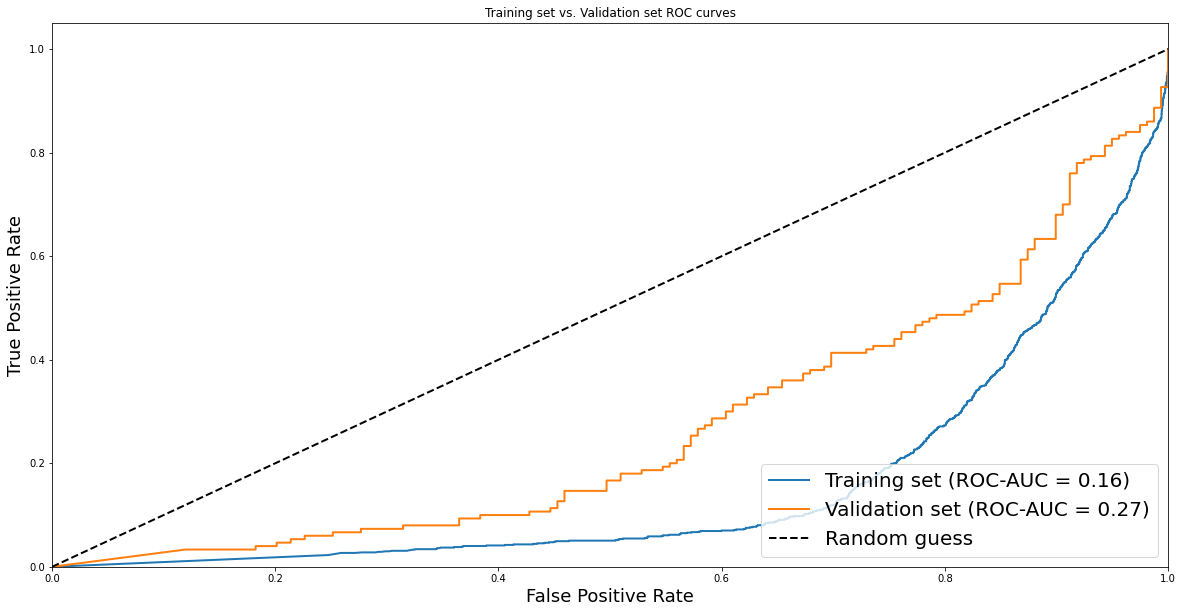

In [139]:
pred = [model(torch.from_numpy(train_x).to(device, dtype=torch.float),torch.from_numpy(train_snr).to(device, dtype=torch.float)).detach().cpu().numpy(),
        model(torch.from_numpy(val_x).to(device, dtype=torch.float),torch.from_numpy(val_snr).to(device, dtype=torch.float)).detach().cpu().numpy()]
actual = [train_y, val_y]
utils.stats(pred, actual)